In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [33]:
class visualizer:
    def __init__(self):
        self.background_color = '#e47911'
        self.palette_hex = ['#e47911', '#232f3e', '#111111', '#48a3c6',
                            '#007eb9', '#cccccc', '#37475a'] #amazon-like palette https://colorswall.com/palette/3835
        self.palette_ccs = ["DarkOrange", "MidnightBlue", "Black", "DodgerBlue", "SteelBlue", 
                            "WhiteSmoke", "DarkSlateGray", "LightGray"] #amazon-like palette in CCS-color names
        self.fig_size = (13, 9) 
        self.label_font_size = 15
        self.title_font_size = 17
        self.bbox_inches='tight'
        self.figure_dpi=200
        self.facecolor="#F0F0F0"
        self.figurecolor='#ffffff'
        self.legend_facecolor='#ffffff'
        self.legend_framealpha=0.5
    
    def visualize_category(self, order_category_gr, caterogy_columns, html_filename):
        order_category_gr=order_category_gr.fillna('nnnn')
        fig = px.treemap(order_category_gr, path=caterogy_columns, values='count', #color='Category_1',    
                color_discrete_sequence = self.palette_ccs,
                title='The physical stores that have seen you the least in recent years')
        #fig.title('This is a somewhat long figure title', fontsize=self.title_font_size)
        fig.data[0]['textfont']['size'] = 20
        #https://github.com/plotly/plotly.py/issues/3589
        figure_data = fig["data"][0]
        mask = np.char.find(figure_data.ids.astype(str), "nnnn") == -1
        figure_data.ids = figure_data.ids[mask]
        figure_data.values = figure_data.values[mask]
        figure_data.labels = figure_data.labels[mask]
        figure_data.parents = figure_data.parents[mask]        
        fig.show()
        fig.write_html(html_filename)
        
    def visualize_orders(self, orders_return, png_filename):
        plt.rcParams["figure.figsize"] = self.fig_size
        #set seaborn plotting aesthetics amazon-like
        sns.set(rc={'axes.facecolor':self.facecolor, 'figure.facecolor':self.figurecolor})
        #create stacked bar chart
        orders_return.plot(kind='barh', stacked=True, color=[self.palette_hex[0], self.palette_hex[1]])
        plt.legend(facecolor=self.legend_facecolor, framealpha=self.legend_framealpha)  
        #add overall title
        plt.title('Your amazon addiction and second thoughts', fontsize=self.title_font_size)
        #add axis titles
        plt.xlabel('Number of orders',fontsize=self.label_font_size)
        plt.ylabel('Year',fontsize=self.label_font_size)
        plt.savefig(png_filename, bbox_inches=self.bbox_inches, dpi=self.figure_dpi)
        
    
    def visualize_expense(self, df_cum, png_filename):     
        # crea la figura e gli assi
        fig, ax = plt.subplots(figsize=self.fig_size)
        ax.set_facecolor(self.facecolor)
        fig.set_facecolor(self.figurecolor)
        color_map = self.palette_hex
        plt.title("How much money you gave to Jeff so far", fontsize=self.title_font_size)
        # disegna lo stackplot
        ax.stackplot(df_cum.index, df_cum.values.T, labels=df_cum.columns,alpha=0.8, colors = color_map)
        # imposta le etichette per le x e le y
        ax.set_xlabel("Year",fontsize=self.label_font_size)
        ax.set_ylabel("Expense €",fontsize=self.label_font_size)
        # mostra la legenda
        ax.legend(loc="upper left",facecolor=self.legend_facecolor, framealpha=self.legend_framealpha)  
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        cum_text_pos=0
        i=-1
        for cat in df_cum.columns:
            i=i+1
            cum_text_pos = cum_text_pos + df_cum.loc[df_cum.index[-1], cat]
            plt.text(x=df_cum.index.max(),
                     y=cum_text_pos - df_cum.loc[df_cum.index[-1], cat]/2,
                     s=f'{int(np.rint(df_cum.loc[df_cum.index[-1], cat]))} €', 
                     color=color_map[i],
                     fontsize=12,
                     fontweight="bold",
                horizontalalignment='left',
                verticalalignment='center',
                #bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}
                    )
        plt.text(x=df_cum.index.max(),
                 y=cum_text_pos,
                 s=f'{int(np.rint(df_cum.sum(axis=1)[-1]))} €', 
                 color="black",
                 fontsize=17,
                 fontweight="bold",
                horizontalalignment='center',
                verticalalignment='bottom')    

        plt.savefig(png_filename, bbox_inches=self.bbox_inches, dpi=self.figure_dpi)
        # mostra il grafico
        plt.show()

In [34]:
v = visualizer()

def visualize_item_by_category(order_data, _max_category_level=3, html_filename='images/categories_tree.html'):
    order_category = order_data.loc[order_data['Refound €'].isna() & order_data['Categories'].str.len() != 0, ["Purchased Price €", "Categories"]]
    # Splitta la colonna Categories in più colonne
    order_category = order_category['Categories'].apply(lambda x: pd.Series(x)).merge(order_category, left_index=True, right_index=True)

    # Rinomina le colonne in base al loro indice
    order_category.rename(columns={i: f'Category_{i+1}' for i in range(order_category.shape[1]-1)}, inplace=True)

    # Drop la colonna Categories originale
    order_category.drop(['Categories'], axis=1, inplace=True)
    order_category = order_category.where(pd.notnull(order_category), None)
    
    max_category_level = _max_category_level
    caterogy_columns = [col for col in order_category if col.startswith('Category_')]
    caterogy_columns = [x for index, x in enumerate(caterogy_columns) if index < max_category_level]
    order_category_gr = order_category.groupby(caterogy_columns, dropna=False)['Purchased Price €'].agg(['sum','count']).reset_index()
    
    v.visualize_category(order_category_gr, caterogy_columns, html_filename)   
    
    
def visualize_orders_by_year(order_data, png_filename='images/orders_by_year.png'):
    order_count = order_data.loc[order_data['Refound €'].isna(), ['Purchased Price €',"Year"]].groupby(['Year']).agg(['count'])
    idx = range(order_count.index.min(), order_count.index.max()+1, 1)
    order_count = order_count.reindex(idx, fill_value=0)
    order_count.columns = order_count.columns.droplevel(0)
    order_count.columns = ['orders']
    
    return_count = order_data.loc[~order_data['Refound €'].isna(), ['Purchased Price €',"Year"]].groupby(['Year']).agg(['count'])
    return_count = return_count.reindex(idx, fill_value=0)
    return_count.columns = return_count.columns.droplevel(0)
    return_count.columns = ['returns']
    
    orders_return = pd.merge(order_count,return_count, left_index=True, right_index=True)
    
    v.visualize_orders(orders_return, png_filename)   
    
    
def cumulative_expense(order_data, categories_of_interest=["Libri", "Elettronica", "Informatica"], png_filename='images/cumulative_expense.png'):
    cumulative_purchase = order_data[['Purchased Price €', 'Refound €', 'Order Date', 'Categories']]
    cumulative_purchase['Net €'] = cumulative_purchase['Purchased Price €'] - cumulative_purchase['Refound €'].fillna(0)
    cumulative_purchase['Category'] = cumulative_purchase['Categories'].str[0]
    cumulative_purchase = cumulative_purchase.groupby(['Order Date', 'Category'])['Net €'].agg(['sum'])
    cumulative_purchase = cumulative_purchase.unstack(level=-1).fillna(0)
    cumulative_purchase = cumulative_purchase.rename_axis(None)
    cumulative_purchase.columns = cumulative_purchase.columns.droplevel()
    
    keep_cols = categories_of_interest
    cumulative_purchase_selected = cumulative_purchase[keep_cols]
    # Somma le restanti colonne
    sum_cols = cumulative_purchase.drop(columns=keep_cols)
    sum_df = sum_cols.sum(axis=1)
    # Aggiungi la somma alle tre colonne mantenute
    cumulative_purchase_selected["Other"] = sum_df    
    # calcola la somma cumulativa per ciascuna categoria
    df_cum = cumulative_purchase_selected.cumsum(axis=0)
    dates = pd.date_range(df_cum.index.min(), df_cum.index.max(), freq="D")
    df_cum.reindex(dates, fill_value=0)
    
    v.visualize_expense(df_cum, png_filename)


In [37]:
order_data.to_pickle("order_data_anonymized_.pkl")

In [38]:
order_data = pd.read_pickle('scrape_amazon_history/order_data.pkl')
order_data['Name'] = '_anonymized_'
order_data['Addressee'] = '_anonymized_'
order_data['Link'] = 'amazon.it/gp/product/_anonymized_'
order_data = order_data.reset_index(drop=True)
order_data.to_pickle("scrape_amazon_history/order_data_anonymized_.pkl")
order_data

,Name,Categories,Purchased Price €,Refound €,Link,Current Price €,Order Date,Day Of Week,Month,Year,Order Total Cost €,Addressee
0,_anonymized_,"[Libri, Letteratura e narrativa, Classici]",12.67,NaN,amazon.it/gp/product/_anonymized_,14.15,2016-06-30,Thursday,June,2016,0.00,_anonymized_
1,_anonymized_,"[Elettronica, Cellulari e accessori, Accessori...",11.99,NaN,amazon.it/gp/product/_anonymized_,12.99,2022-02-27,Sunday,February,2022,0.00,_anonymized_
2,_anonymized_,"[Libri, Letteratura e narrativa, Narrativa con...",13.60,NaN,amazon.it/gp/product/_anonymized_,15.20,2020-03-08,Sunday,March,2020,0.00,_anonymized_
3,_anonymized_,"[Elettronica, Cuffie, auricolari e accessori, ...",7.99,NaN,amazon.it/gp/product/_anonymized_,NaN,2019-02-13,Wednesday,February,2019,0.00,_anonymized_
4,_anonymized_,"[Alimentari e cura della casa, Caffè, tè e bev...",22.62,NaN,amazon.it/gp/product/_anonymized_,NaN,2022-11-28,Monday,November,2022,0.55,_anonymized_
...,...,...,...,...,...,...,...,...,...,...,...,...
414,_anonymized_,"[Bellezza, Cura della pelle, Viso, Detergenti ...",9.99,NaN,amazon.it/gp/product/_anonymized_,NaN,2020-08-10,Monday,August,2020,0.00,_anonymized_
415,_anonymized_,"[Moda, Uomo, Abbigliamento, Giacche e cappotti...",54.98,82.98,amazon.it/gp/product/_anonymized_,NaN,2022-04-12,Tuesday,April,2022,0.00,_anonymized_
416,_anonymized_,"[Giochi e giocattoli, Giochi da tavola, di soc...",9.68,NaN,amazon.it/gp/product/_anonymized_,15.99,2018-12-04,Tuesday,December,2018,0.00,_anonymized_
417,_anonymized_,"[Libri, Arte, cinema e fotografia, Film]",15.30,NaN,amazon.it/gp/product/_anonymized_,17.10,2015-01-20,Tuesday,January,2015,0.00,_anonymized_


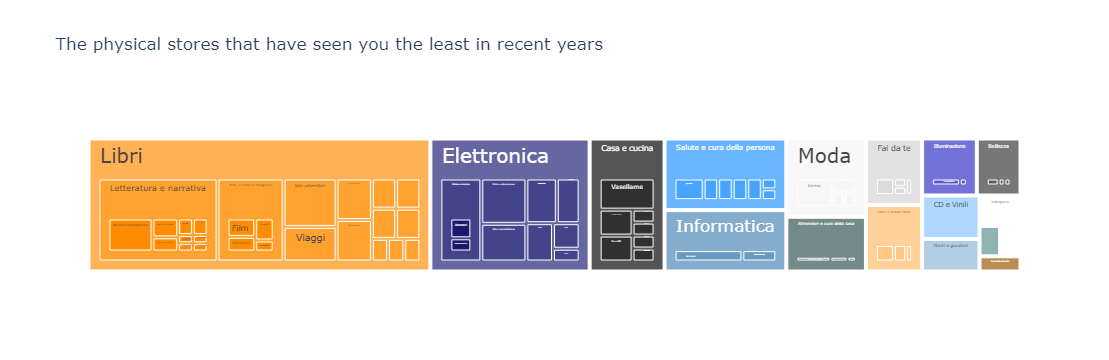

In [39]:
visualize_item_by_category(order_data)

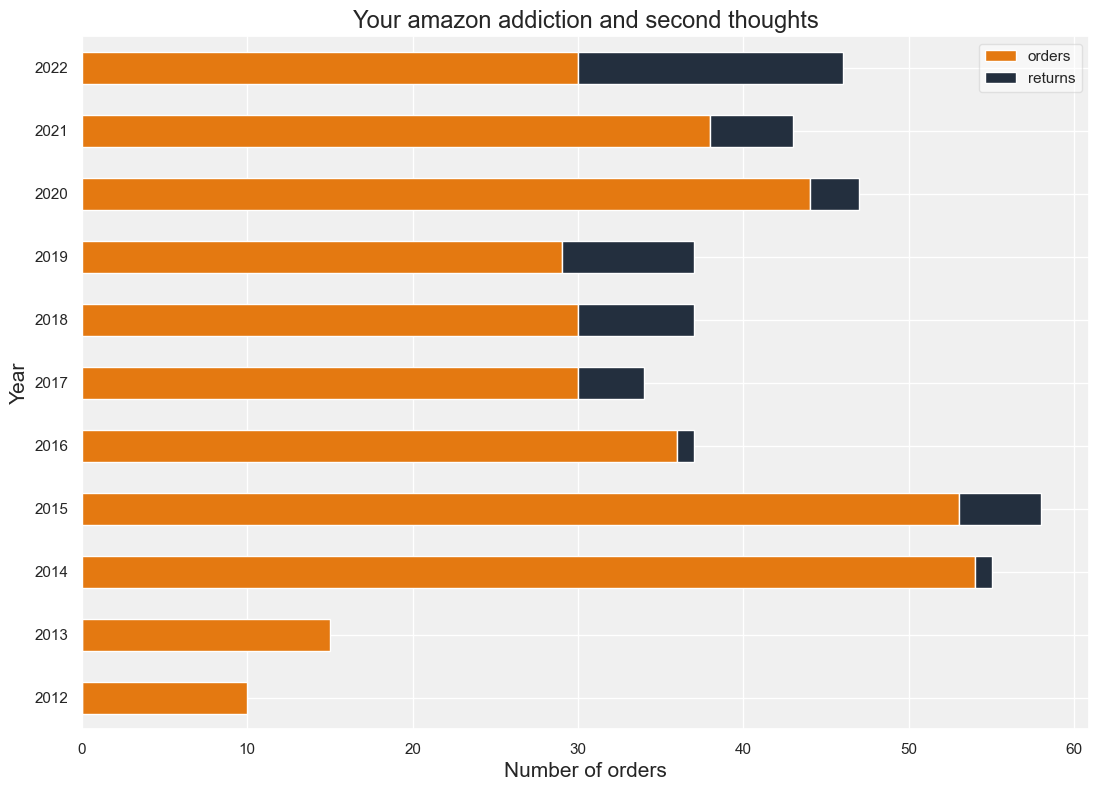

In [40]:
visualize_orders_by_year(order_data)

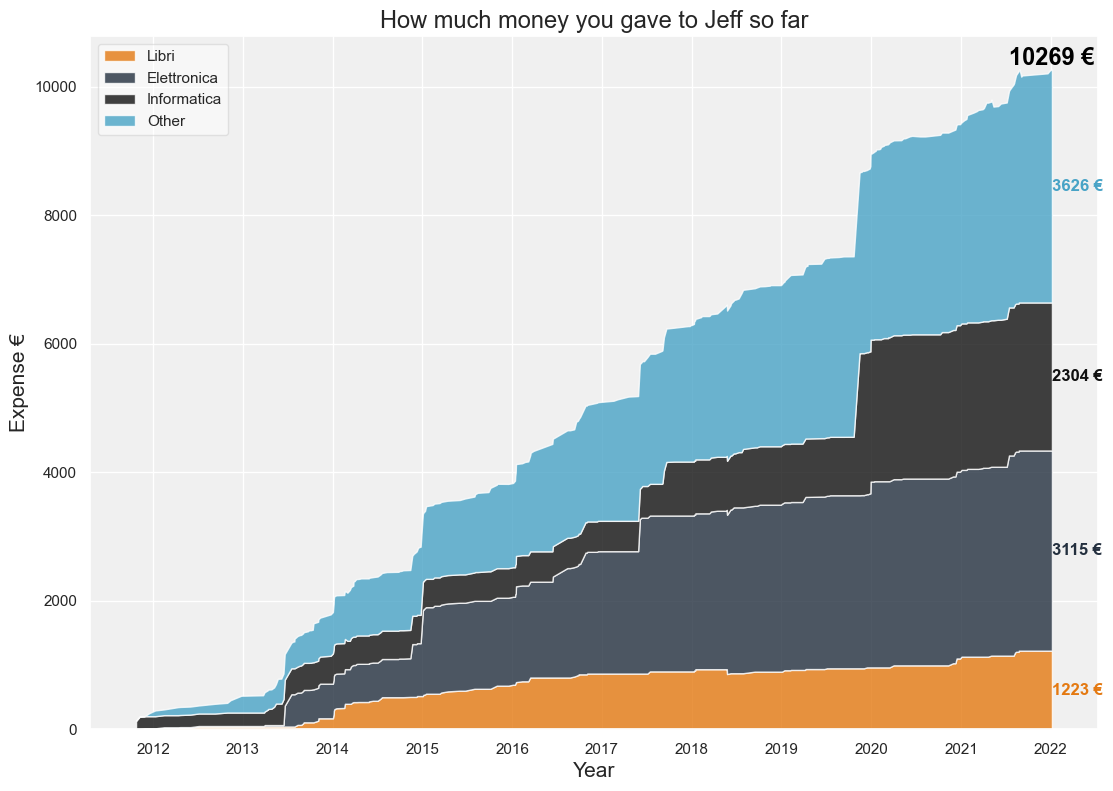

In [41]:
cumulative_expense(order_data)